In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--exp-name', 'baseline_scNT',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


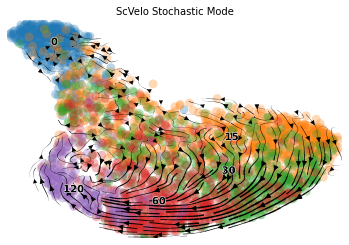

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18046935, ('15', '30'): 0.18492216, ('30', '60'): 0.23317614, ('60', '120'): 0.26242688}
Total Mean: 0.21524861454963684
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.8819014, ('15', '30'): 0.8492638, ('30', '60'): 0.88575584, ('60', '120'): 0.94947964}
Total Mean: 0.8916001319885254
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.1876439061902281, ('15', '30'): 0.18311435541804788, ('30', '60'): 0.2605115613326429, ('60', '120'): 0.3797041202025015}
Total Mean: 0.2527434857858551
# In-cluster Coherence
{'0': 0.9148035, '120': 0.9610712, '15': 0.86902803, '30': 0.8744441, '60': 0.9512439}
Total Mean: 0.9141181707382202
# In-cluster Confidence
{'0': 0.5655437985422628, '120': 0.521134286881443, '15': 0.5152934900207046, '30': 0.5523746173429888, '60': 0.6306864593274655}
Total Mean: 0.5570065304229729


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['time'],
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 6.082365
Train Epoch: 200/20000 	Loss: 6.066597
Train Epoch: 300/20000 	Loss: 6.048918
Train Epoch: 400/20000 	Loss: 6.027510
Train Epoch: 500/20000 	Loss: 6.001288
Train Epoch: 600/20000 	Loss: 5.971164
Train Epoch: 700/20000 	Loss: 5.937890
Train Epoch: 800/20000 	Loss: 5.902301
Train Epoch: 900/20000 	Loss: 5.864525
Train Epoch: 1000/20000 	Loss: 5.824932
Train Epoch: 1100/20000 	Loss: 5.783374
Train Epoch: 1200/20000 	Loss: 5.739642
Train Epoch: 1300/20000 	Loss: 5.693736
Train Epoch: 1400/20000 	Loss: 5.645824
Train Epoch: 1500/20000 	Loss: 5.595564
Train Epoch: 1600/20000 	Loss: 5.542746
Train Epoch: 1700/20000 	Loss: 5.487476
Train Epoch: 1800/20000 	Loss: 5.429486
Train Epoch: 1900/20000 	Loss: 5.369146
Train Epoch: 2000/20000 	Loss: 5.306538
Train Epoch: 2100/20000 	Loss: 5.241901
Train Epoch: 2200/20000 	Loss: 5.175319
Train Epoch: 2300/20000 	Loss: 5.107041
Train Epoch: 2400/20000 	Loss: 5.036990
Train Epoch: 2500/20000 	Loss: 4.965188
Train Epo

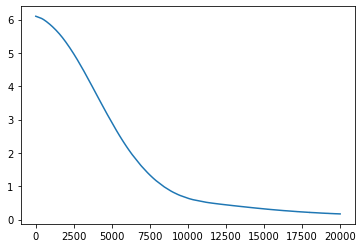

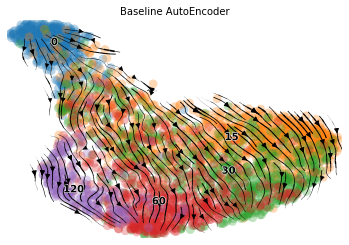

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.139092, ('15', '30'): 0.1297292, ('30', '60'): 0.04144244, ('60', '120'): 0.040388405}
Total Mean: 0.08766300976276398
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9999813, ('15', '30'): 0.9999785, ('30', '60'): 0.99997723, ('60', '120'): 0.99997425}
Total Mean: 0.9999778270721436
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.538949403000768, ('15', '30'): 0.4114306934986493, ('30', '60'): 0.18194589954375384, ('60', '120'): -0.16088157253502908}
Total Mean: 0.24286110587703555
# In-cluster Coherence
{'0': 0.99998486, '120': 0.99998575, '15': 0.9999817, '30': 0.9999809, '60': 0.99998057}
Total Mean: 0.9999827146530151
# In-cluster Confidence
{'0': 0.9999756914390547, '120': 0.999972565240594, '15': 0.9999734339913773, '30': 0.999972064322656, '60': 0.9

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 6.065242
Train Epoch: 200/20000 	Loss: 6.058659
Train Epoch: 300/20000 	Loss: 6.050339
Train Epoch: 400/20000 	Loss: 6.039120
Train Epoch: 500/20000 	Loss: 6.024547
Train Epoch: 600/20000 	Loss: 6.007244
Train Epoch: 700/20000 	Loss: 5.988045
Train Epoch: 800/20000 	Loss: 5.967262
Train Epoch: 900/20000 	Loss: 5.944831
Train Epoch: 1000/20000 	Loss: 5.920624
Train Epoch: 1100/20000 	Loss: 5.894538
Train Epoch: 1200/20000 	Loss: 5.866503
Train Epoch: 1300/20000 	Loss: 5.836477
Train Epoch: 1400/20000 	Loss: 5.804450
Train Epoch: 1500/20000 	Loss: 5.770453
Train Epoch: 1600/20000 	Loss: 5.734593
Train Epoch: 1700/20000 	Loss: 5.696998
Train Epoch: 1800/20000 	Loss: 5.657773
Train Epoch: 

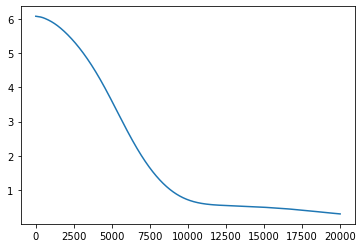

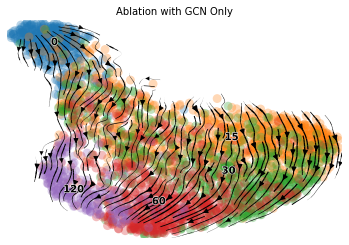

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.07072162, ('15', '30'): 0.07364025, ('30', '60'): 0.04052507, ('60', '120'): 0.05999698}
Total Mean: 0.06122097745537758
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9999897, ('15', '30'): 0.9999897, ('30', '60'): 0.9999903, ('60', '120'): 0.9999916}
Total Mean: 0.9999903440475464
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6867507772163569, ('15', '30'): 0.47303187784218387, ('30', '60'): 0.3298957810741781, ('60', '120'): 0.25521917091975777}
Total Mean: 0.43622440176311916
# In-cluster Coherence
{'0': 0.99999154, '120': 0.999994, '15': 0.99999046, '30': 0.999991, '60': 0.99999225}
Total Mean: 0.999991774559021
# In-cluster Confidence
{'0': 0.9999901498990837, '120': 0.9999921599707281, '15': 0.999989899852513, '30': 0.9999900619410009, '60': 0.999

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 6.023997
Train Epoch: 200/20000 	Loss: 5.980543
Train Epoch: 300/20000 	Loss: 5.814573
Train Epoch: 400/20000 	Loss: 5.570837
Train Epoch: 500/20000 	Loss: 5.313564
Train Epoch: 600/20000 	Loss: 5.082922
Train Epoch: 700/20000 	Loss: 4.904550
Train Epoch: 800/20000 	Loss: 4.771224
Train Epoch: 900/20000 	Loss: 4.661992
Train Epoch: 1000/20000 	Loss: 4.566127
Train Epoch: 1100/20000 	Loss: 4.480375
Train Epoch: 1200/20000 	Loss: 4.402270
Train Epoch: 1300/20000 	Loss: 4.329597
Train Epoch: 1400/20000 	Loss: 4.260653
Train Epoch: 1500/20000 	Loss: 4.196550
Train Epoch: 1600/20000 	Loss: 4.133164
Train Epoch: 1700/20000 	Loss: 4.075895
Train Epoch: 1800/20000 	Loss: 4.024777
Train Epoch: 1900/20000 	Loss: 3.969154
Train Epoch: 2000/20000 	Loss: 3.922707
Train Epoch: 2100/20000 	Loss: 3.867763
Train Epoch: 2200/20000 	Loss: 3.818296
Train Epoch: 2300/20000 	Loss: 3.769996
Train Epoch: 2400/20000 	Loss: 3.720763
Train Epoch: 2500/20000 	Loss: 3.677573
Train Epo

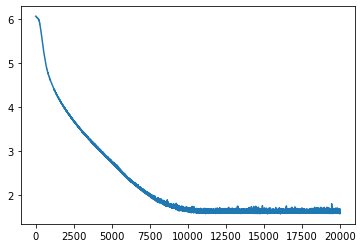

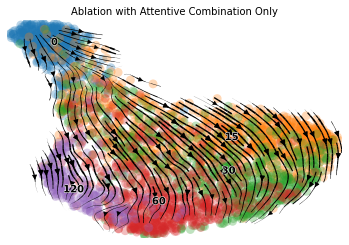

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.4965116, ('15', '30'): 0.50845766, ('30', '60'): 0.3123672, ('60', '120'): 0.38906658}
Total Mean: 0.42660075426101685
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9989313, ('15', '30'): 0.9990102, ('30', '60'): 0.9989625, ('60', '120'): 0.9988959}
Total Mean: 0.9989499449729919
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6845570235922741, ('15', '30'): 0.44365548912770125, ('30', '60'): 0.2598910198361182, ('60', '120'): -0.049633207404961514}
Total Mean: 0.334617581287783
# In-cluster Coherence
{'0': 0.99905205, '120': 0.9992588, '15': 0.99913436, '30': 0.99913335, '60': 0.9990011}
Total Mean: 0.9991159439086914
# In-cluster Confidence
{'0': 0.9990536347864991, '120': 0.9990983477151726, '15': 0.9991466308139382, '30': 0.9991183721969455, '60': 0.9

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


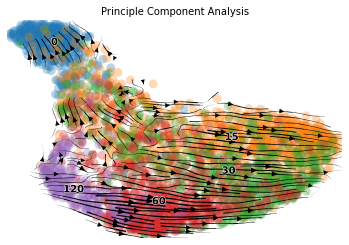

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.04899225, ('15', '30'): 0.055763878, ('30', '60'): 0.037247803, ('60', '120'): 0.01787589}
Total Mean: 0.03996995836496353
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.381313, ('15', '30'): 0.330331, ('30', '60'): 0.29319173, ('60', '120'): 0.31029093}
Total Mean: 0.3287816643714905
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): -0.5585309098164946, ('15', '30'): -0.05370698508470263, ('30', '60'): -0.22781785133323745, ('60', '120'): -0.5694411152719574}
Total Mean: -0.352374215376598
# In-cluster Coherence
{'0': 0.49978513, '120': 0.41026002, '15': 0.39112958, '30': 0.40324757, '60': 0.4056548}
Total Mean: 0.4220154285430908
# In-cluster Confidence
{'0': 0.4015563001879126, '120': 0.3063665648822142, '15': 0.35120360291872604, '30': 0.33788195072630517,

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


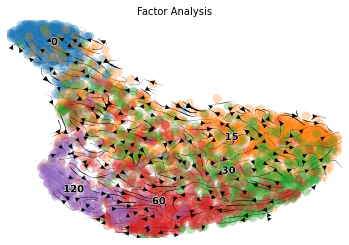

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.025272492, ('15', '30'): 0.02354262, ('30', '60'): 0.025952902, ('60', '120'): 0.02041347}
Total Mean: 0.023795370012521744
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.06177982757011682, ('15', '30'): 0.11054250795910654, ('30', '60'): 0.07411032781983216, ('60', '120'): 0.12959278817615114}
Total Mean: 0.09400636288130165
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.013653981951087489, ('15', '30'): -0.004989576350395838, ('30', '60'): 0.028657873714502284, ('60', '120'): -0.15744081540593155}
Total Mean: -0.030029634022684402
# In-cluster Coherence
{'0': 0.36904049112167175, '120': 0.29823432793282917, '15': 0.16606947575342537, '30': 0.2714671841689818, '60': 0.2386690231146911}
Total Mean: 0.2686961004183198
# In-cluster Confidence
{'0': 0.178720

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)